In [1]:
import numpy as np
import pandas as pd
import os 
import six
import seaborn as sn
import matplotlib.pyplot as plt
from utils.test_util import calc_divgenerce
from utils.data_util import save_samples, extract_data, load_inception_net
from aggre_results import *

In [2]:
import matplotlib as mtp
mtp.rcParams['pdf.fonttype'] = 42
mtp.rcParams['ps.fonttype'] = 42

In [3]:
%matplotlib inline

In [4]:
def aggreate_divergence(path):
    sd = os.listdir(path)
    data = []
    for s in sd:
        print(s)
        if '.' in s:
            continue

        ds = np.loadtxt(os.path.join(path,s,'divergence_compare.csv'),delimiter=',')
        #ds = np.loadtxt(path+s+'/kl.csv',delimiter=',')
        data.append(ds)
    n = len(data)
    data = np.vstack(data)
    data = data.reshape(n,-1,data.shape[-1])
    return data

In [5]:
def aggreate_score(path,stype='fid',file_id=[0]):
    sd = os.listdir(path)
    data = []
    for s in sd:
        print(s)
        if '.' in s:
            continue
        #print(path+s+'/'+stype+'.csv')
        if stype in ['prd_seg','prd_half']:
            for fi in file_id:
                #print('fi',fi)
                ds = np.loadtxt(os.path.join(path,s)+'/'+stype+str(fi)+'.csv',delimiter=',')
                data.append(ds)
                #print(len(data))
        else:
            ds = np.loadtxt(os.path.join(path,s)+'/'+stype+'.csv',delimiter=',')
        #print(ds.shape)
        if stype in ['fid','kl','prd']:
            #print('load score',ds)
            data.append(ds)
            
        elif stype == 'kid':
            if len(ds.shape) > 1:
                data.append(ds[:,0])
            else:
                data.append(ds[0])
    n = len(data)
    #print(n)
    if 'prd' not in stype:
        data = np.vstack(data)
        data = data.reshape(n,data.shape[-1])
        
    return data

In [6]:
def get_divergence(data,type='kl'):
    if type == 'kl':
        t = 0
        e = 1
    elif type == 'tv':
        t = 5
        e = 6
    elif type == 'chi':
        t = 7
        e = 8
        
    true_mean = np.mean(data[:,t,:],axis=0)
    true_std = np.std(data[:,t,:],axis=0)
    est_mean = np.mean(data[:,e,:],axis=0)
    est_std = np.std(data[:,e,:],axis=0)
    
    return true_mean,true_std,est_mean,est_std

In [7]:
def get_divergence_err(data,type='kl'):
    if type == 'kl':
        t = 0
        e = 1
    elif type == 'tv':
        t = 5
        e = 6
    elif type == 'chi':
        t = 7
        e = 8
        
    true_mean = np.mean(data[:,t,:],axis=0)
    true_std = np.std(data[:,t,:],axis=0)
    est_err_mean = np.mean(np.abs(data[:,e,:]-true_mean),axis=0)
    est_err_std = np.std(np.abs(data[:,e,:]-true_mean),axis=0)
    
    return true_mean,true_std,est_err_mean,est_err_std

In [8]:
def get_ratio_err(data,type='mae'):
    rt = []
    for ds in data:
        rt_s = []
        for ds_t in ds:
            if 'log' not in type: 
                estd = np.exp(ds_t[:,1])
                true = np.exp(ds_t[:,2])
            else:
                estd = ds_t[:,1]
                true = ds_t[:,2]
            if 'mae' in type:
                err = np.mean(np.abs(estd-true))
            elif 'mse' in type:
                err = np.mean(np.square(estd-true))
                    
            rt_s.append(err)
        rt.append(rt_s)
    return rt

In [9]:
def aggregate_ratio(path,T=10):
    sd = os.listdir(path)
    data = []
    for s in sd:
        print(os.path.join(path,s))
        if '.' in s:
            continue
        dt = []
        for t in range(T):
            try:
                ds = pd.read_csv(os.path.join(path,s,'sample_ratios_t_t'+str(t+1)+'.csv')).values
                dt.append(ds)
            except FileNotFoundError:
                #print('file not found',os.path.join(path,s,'sample_ratios_t_t'+str(t+1)+'.csv'))
                continue
        data.append(dt)
    return data

In [10]:
def cal_div_by_ratio(div_type,paths,T=10,S=10,condition=False):
    div_means,div_stds = [],[]
    true_divs=[]
    for p in paths:
        print(p)
        data = aggregate_ratio(p,T)
        divs=[]
        tdiv = []
        for s in range(S):
            if T>1:
                ds = []
                true = []
                for t in range(len(data[s])):
                    #print(s,t)
                    rd = data[s][t]
                    
                    samples_c = one_hot_encoder(rd[:,-1],T) if condition else None
                    div = calc_divgenerce(div_type,[rd[:,1]],samples_c)
                    true_div = calc_divgenerce(div_type,[rd[:,2]],samples_c)
                    #print(div)
                    if condition:
                        ds.append(div[0][:t+1].mean())
                        true.append(true_div[0][:t+1].mean())
                    else:
                        ds.append(div[0])
                        true.append(true_div[0])
                    #print(ds[-1])
                divs.append(ds)
                tdiv.append(true)
            else:
                div = calc_divgenerce(div_type,[data[s]])
                divs.append(div)

        divs=np.vstack(divs)
        d_mean = np.mean(divs,axis=0)
        d_std = np.std(divs,axis=0)
        div_means.append(d_mean)
        div_stds.append(d_std)
        true_divs.append(np.array(tdiv))
    return div_means,div_stds,true_divs

In [11]:
def aggregate_paths(paths,ftype='div',file_id=[0]):
    data = []
    for p in paths:
        if ftype=='div':
            d = aggreate_divergence(p)
        elif ftype in ['fid','kid','kl','prd','prd_seg','prd_half']:
            d = aggreate_score(p,ftype,file_id)
        data.append(d)
    return data

In [12]:
# max number of time steps for computing
t_num = 20  
# number of runs
S = 10
# path of result files, one path includes results of multiple runs by one configuration
path = '../results/cl_d64_s50000_kl/'
paths = ['dre_t20','cdre_t20','cdre_t5']
paths = [os.path.join(path,p) for p in paths]

In [13]:
# get KL divergence 
kl_means,kl_stds = [],[]
for path in paths:
    data = aggreate_divergence(path)
    true_kl_mean,true_kl_std,kl_mean,kl_std = get_divergence(data,type='kl')
    kl_means.append(kl_mean)
    kl_stds.append(kl_std)

cl_ratio_test_d64_Wed-Aug-12-021540-2020
cl_ratio_test_d64_Wed-Aug-12-023440-2020
cl_ratio_test_d64_Wed-Aug-12-022430-2020
cl_ratio_test_d64_Wed-Aug-12-022019-2020
cl_ratio_test_d64_Tue-Aug-11-225541-2020
cl_ratio_test_d64_Wed-Aug-12-022945-2020
cl_ratio_test_d64_Wed-Aug-12-021042-2020
cl_ratio_test_d64_Wed-Aug-12-023947-2020
cl_ratio_test_d64_Wed-Aug-12-024840-2020
cl_ratio_test_d64_Wed-Aug-12-024405-2020
cl_ratio_test_d64_Wed-Aug-12-013540-2020
cl_ratio_test_d64_Wed-Aug-12-004701-2020
cl_ratio_test_d64_Wed-Aug-12-002422-2020
cl_ratio_test_d64_Wed-Aug-12-015856-2020
cl_ratio_test_d64_Wed-Aug-12-010027-2020
cl_ratio_test_d64_Wed-Aug-12-012139-2020
cl_ratio_test_d64_Wed-Aug-12-001244-2020
cl_ratio_test_d64_Tue-Aug-11-220539-2020
cl_ratio_test_d64_Wed-Aug-12-003632-2020
cl_ratio_test_d64_Wed-Aug-12-011011-2020
cl_ratio_test_d64_Tue-Aug-11-222334-2020
cl_ratio_test_d64_Wed-Aug-12-014701-2020
cl_ratio_test_d64_Wed-Aug-12-122515-2020
cl_ratio_test_d64_Wed-Aug-12-121758-2020
cl_ratio_test_d6

In [14]:
# compute log MAE of ratios
err_means, err_stds = [], []
ratios=[]
for path in paths:
    data = aggregate_ratio(path,T=t_num)
    err = get_ratio_err(data,type='logmae')
    err = np.array(err)
    err_means.append(np.mean(err,axis=0))
    err_stds.append(np.std(err,axis=0))
    ratios.append(data)

../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-021540-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-023440-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-022430-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-022019-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Tue-Aug-11-225541-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-022945-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-021042-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-023947-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-024840-2020
../results/cl_d64_s50000_kl/dre_t20/cl_ratio_test_d64_Wed-Aug-12-024405-2020
../results/cl_d64_s50000_kl/cdre_t20/cl_ratio_test_d64_Wed-Aug-12-013540-2020
../results/cl_d64_s50000_kl/cdre_t20/cl_ratio_test_d64_Wed-Aug-12-004701-2020
../results/cl_d64_s50000_kl/cdre_t20/cl_ratio_test_d64_Wed-Aug-12-002422-2

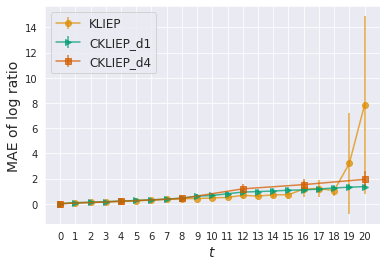

In [15]:
## visualize comparison of log MAE

sn.set_style('darkgrid')
cmp = sn.color_palette("colorblind")
markers = ['o','>','s','*']

for i,(err_mean,err_std) in enumerate(zip(err_means,err_stds)):
    T=np.arange(0,t_num+1,int(t_num/len(err_mean)))
    plt.errorbar(T,[0]+list(err_mean),yerr=[0]+list(err_std),alpha=0.75,marker=markers[i],color=cmp[i+1])
      
plt.legend([r'KLIEP',r'CKLIEP_d1',r'CKLIEP_d4'],fontsize=12,loc=2)
plt.xlabel(r'$t$',fontsize=14)
plt.ylabel('MAE of log ratio',fontsize=14)
plt.xticks(np.arange(t_num+1))
plt.savefig(os.path.join(path,'logr_MAE.pdf'))

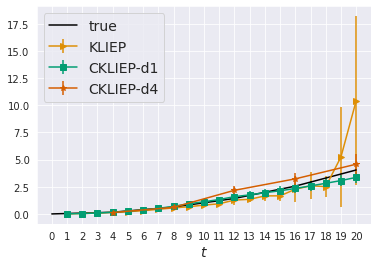

In [16]:
cmp = sn.color_palette("colorblind")
T=np.arange(0,t_num+1,int(t_num/len(true_kl_mean)))
plt.plot(T,[0]+list(true_kl_mean),color='k') 
for i,(div_mean,div_std) in enumerate(zip(kl_means,kl_stds)):
    T=np.arange(0,t_num+1,int(t_num/len(div_mean)))
    plt.errorbar(T[1:],div_mean,yerr=div_std,color=cmp[i+1],marker=markers[i+1])
    #plt.fill_between(T[1:],div_mean-div_std,div_mean+div_std,alpha=0.3,color=cmp[i+1])
    

plt.legend(['true',r'KLIEP',r'CKLIEP-d1',r'CKLIEP-d4'],fontsize=14,loc=2)    

plt.xlabel(r'$t$',fontsize=14)

plt.xticks(np.arange(t_num+1))
plt.savefig(os.path.join(path,'compare_kl.pdf'))